#Imports

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)
from sklearn.decomposition import PCA

#Loading DataSets

In [36]:
url = "https://raw.githubusercontent.com/SaikotCSE/ml_lab/main/Heart_Disease_Prediction.csv"
df = pd.read_csv(url)

df.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


#Data Preprocessing & Encoding

In [37]:
df = df.fillna(df.mean(numeric_only=True))

for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop('Heart Disease', axis=1)
y = df['Heart Disease']

#Feature Scaling

In [38]:
Scaler = StandardScaler()
X_scaled = Scaler.fit_transform(X)

#Train_Test_Split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

#CART (Gini) – Hyperparameter Tuning

In [40]:
cart = DecisionTreeClassifier(criterion='gini', random_state=42)

cart_params = {
    'max_depth': [2, 3, 4, 5, 6, 8, 10],
    'min_samples_split': [2, 5, 10, 20]
}

cart_grid = GridSearchCV(
    cart, cart_params, cv=5, scoring='f1', n_jobs=-1
)
cart_grid.fit(X_train, y_train)

best_cart = cart_grid.best_estimator_

#ID3 (Entropy) – Hyperparameter Tuning

In [41]:
id3 = DecisionTreeClassifier(criterion='entropy', random_state=42)

id3_params = {
    'max_depth': [2, 3, 4, 5, 6, 8, 10],
    'min_samples_split': [2, 5, 10, 20]
}

id3_grid = GridSearchCV(
    id3, id3_params, cv=5, scoring='f1', n_jobs=-1
)
id3_grid.fit(X_train, y_train)

best_id3 = id3_grid.best_estimator_

#Evaluation of Models

In [42]:
def evaluate(model, X, y):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]

    return {
        "accuracy": accuracy_score(y, y_pred),
        "precision": precision_score(y, y_pred),
        "recall": recall_score(y, y_pred),
        "f1": f1_score(y, y_pred),
        "auc": roc_auc_score(y, y_prob),
        "cm": confusion_matrix(y, y_pred),
        "fpr": roc_curve(y, y_prob)[0],
        "tpr": roc_curve(y, y_prob)[1]
    }

In [43]:
def print_evaluation(name, res):
    print("=" * 45)
    print(f"Evaluation Metrics — {name}")
    print("=" * 45)
    print(f"Accuracy  : {res['accuracy']:.4f}")
    print(f"Precision : {res['precision']:.4f}")
    print(f"Recall    : {res['recall']:.4f}")
    print(f"F1-score  : {res['f1']:.4f}")
    print(f"AUC       : {res['auc']:.4f}")
    print("=" * 45)
    print()

In [44]:
cart_res = evaluate(best_cart, X_test, y_test)
print_evaluation("CART", cart_res)
id3_res = evaluate(best_id3, X_test, y_test)
print_evaluation("ID3", id3_res)

Evaluation Metrics — CART
Accuracy  : 0.7500
Precision : 0.7097
Recall    : 0.7333
F1-score  : 0.7213
AUC       : 0.8465

Evaluation Metrics — ID3
Accuracy  : 0.7353
Precision : 0.7000
Recall    : 0.7000
F1-score  : 0.7000
AUC       : 0.7570



#Confusion Matrix (2×1 Comparison)

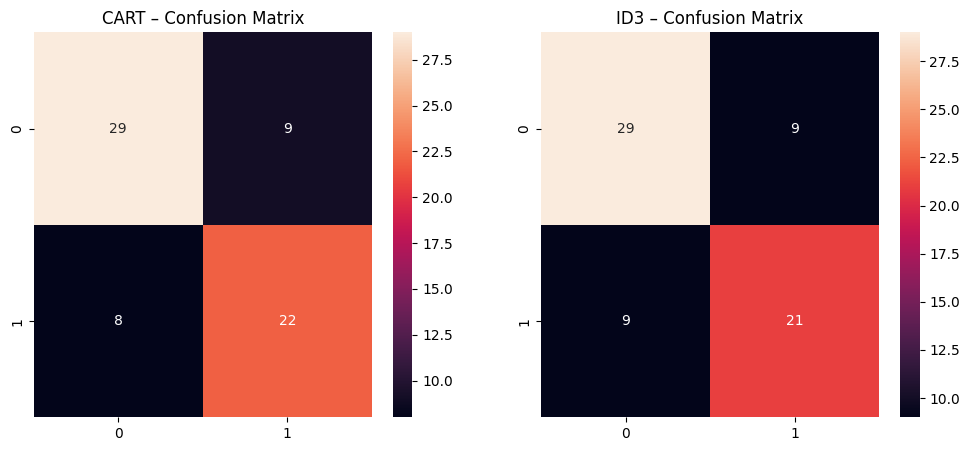

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cart_res["cm"], annot=True, fmt='d', ax=axes[0])
axes[0].set_title("CART – Confusion Matrix")

sns.heatmap(id3_res["cm"], annot=True, fmt='d', ax=axes[1])
axes[1].set_title("ID3 – Confusion Matrix")

plt.show()

#ROC Curve (2×1 Comparison)

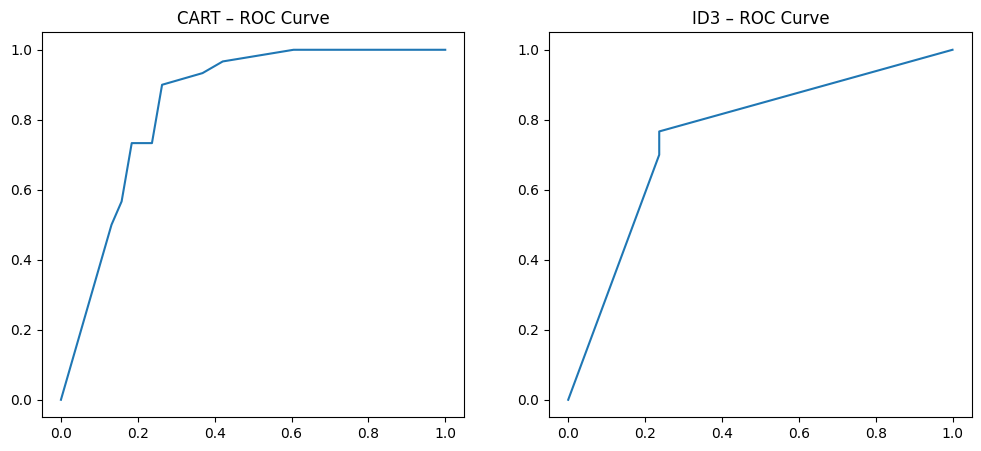

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(cart_res["fpr"], cart_res["tpr"])
axes[0].set_title("CART – ROC Curve")

axes[1].plot(id3_res["fpr"], id3_res["tpr"])
axes[1].set_title("ID3 – ROC Curve")

plt.show()

#Evaluation Metrics Bar Chart

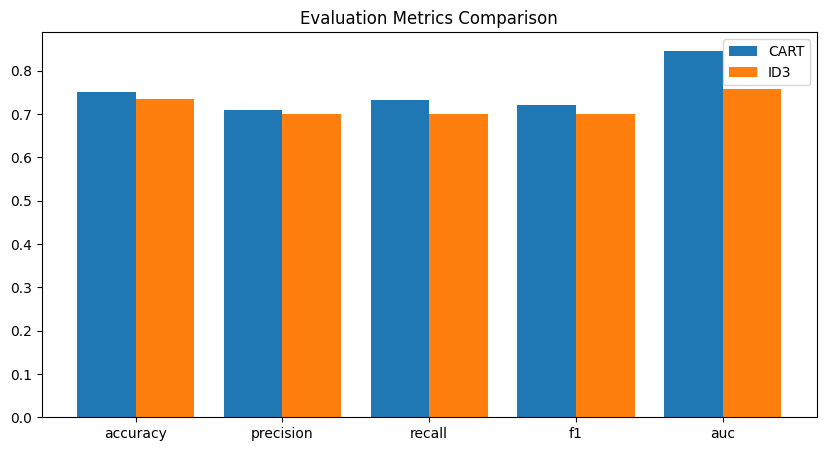

In [47]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']

cart_vals = [cart_res[m] for m in metrics]
id3_vals = [id3_res[m] for m in metrics]

x = np.arange(len(metrics))

plt.figure(figsize=(10,5))
plt.bar(x - 0.2, cart_vals, 0.4, label='CART')
plt.bar(x + 0.2, id3_vals, 0.4, label='ID3')
plt.xticks(x, metrics)
plt.legend()
plt.title("Evaluation Metrics Comparison")
plt.show()

#Decision Boundary (2D PCA – 2×1)

In [48]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

cart_2d = DecisionTreeClassifier(**cart_grid.best_params_)
cart_2d.fit(X_pca, y_train)

id3_2d = DecisionTreeClassifier(**id3_grid.best_params_, criterion='entropy')
id3_2d.fit(X_pca, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=8)

In [49]:
def plot_boundary(model, X, y, ax, title):
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:,0], X[:,1], c=y, edgecolor='k')
    ax.set_title(title)

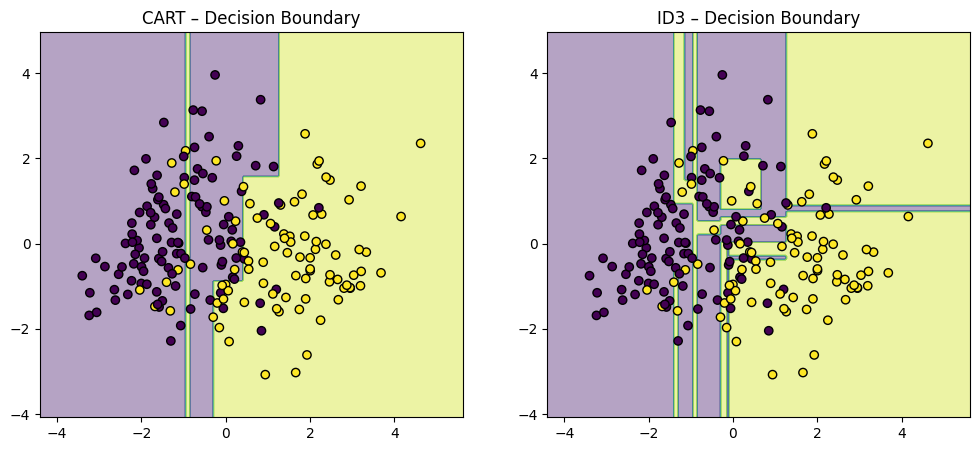

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_boundary(cart_2d, X_pca, y_train, axes[0], "CART – Decision Boundary")
plot_boundary(id3_2d, X_pca, y_train, axes[1], "ID3 – Decision Boundary")
plt.show()

#DT Structure

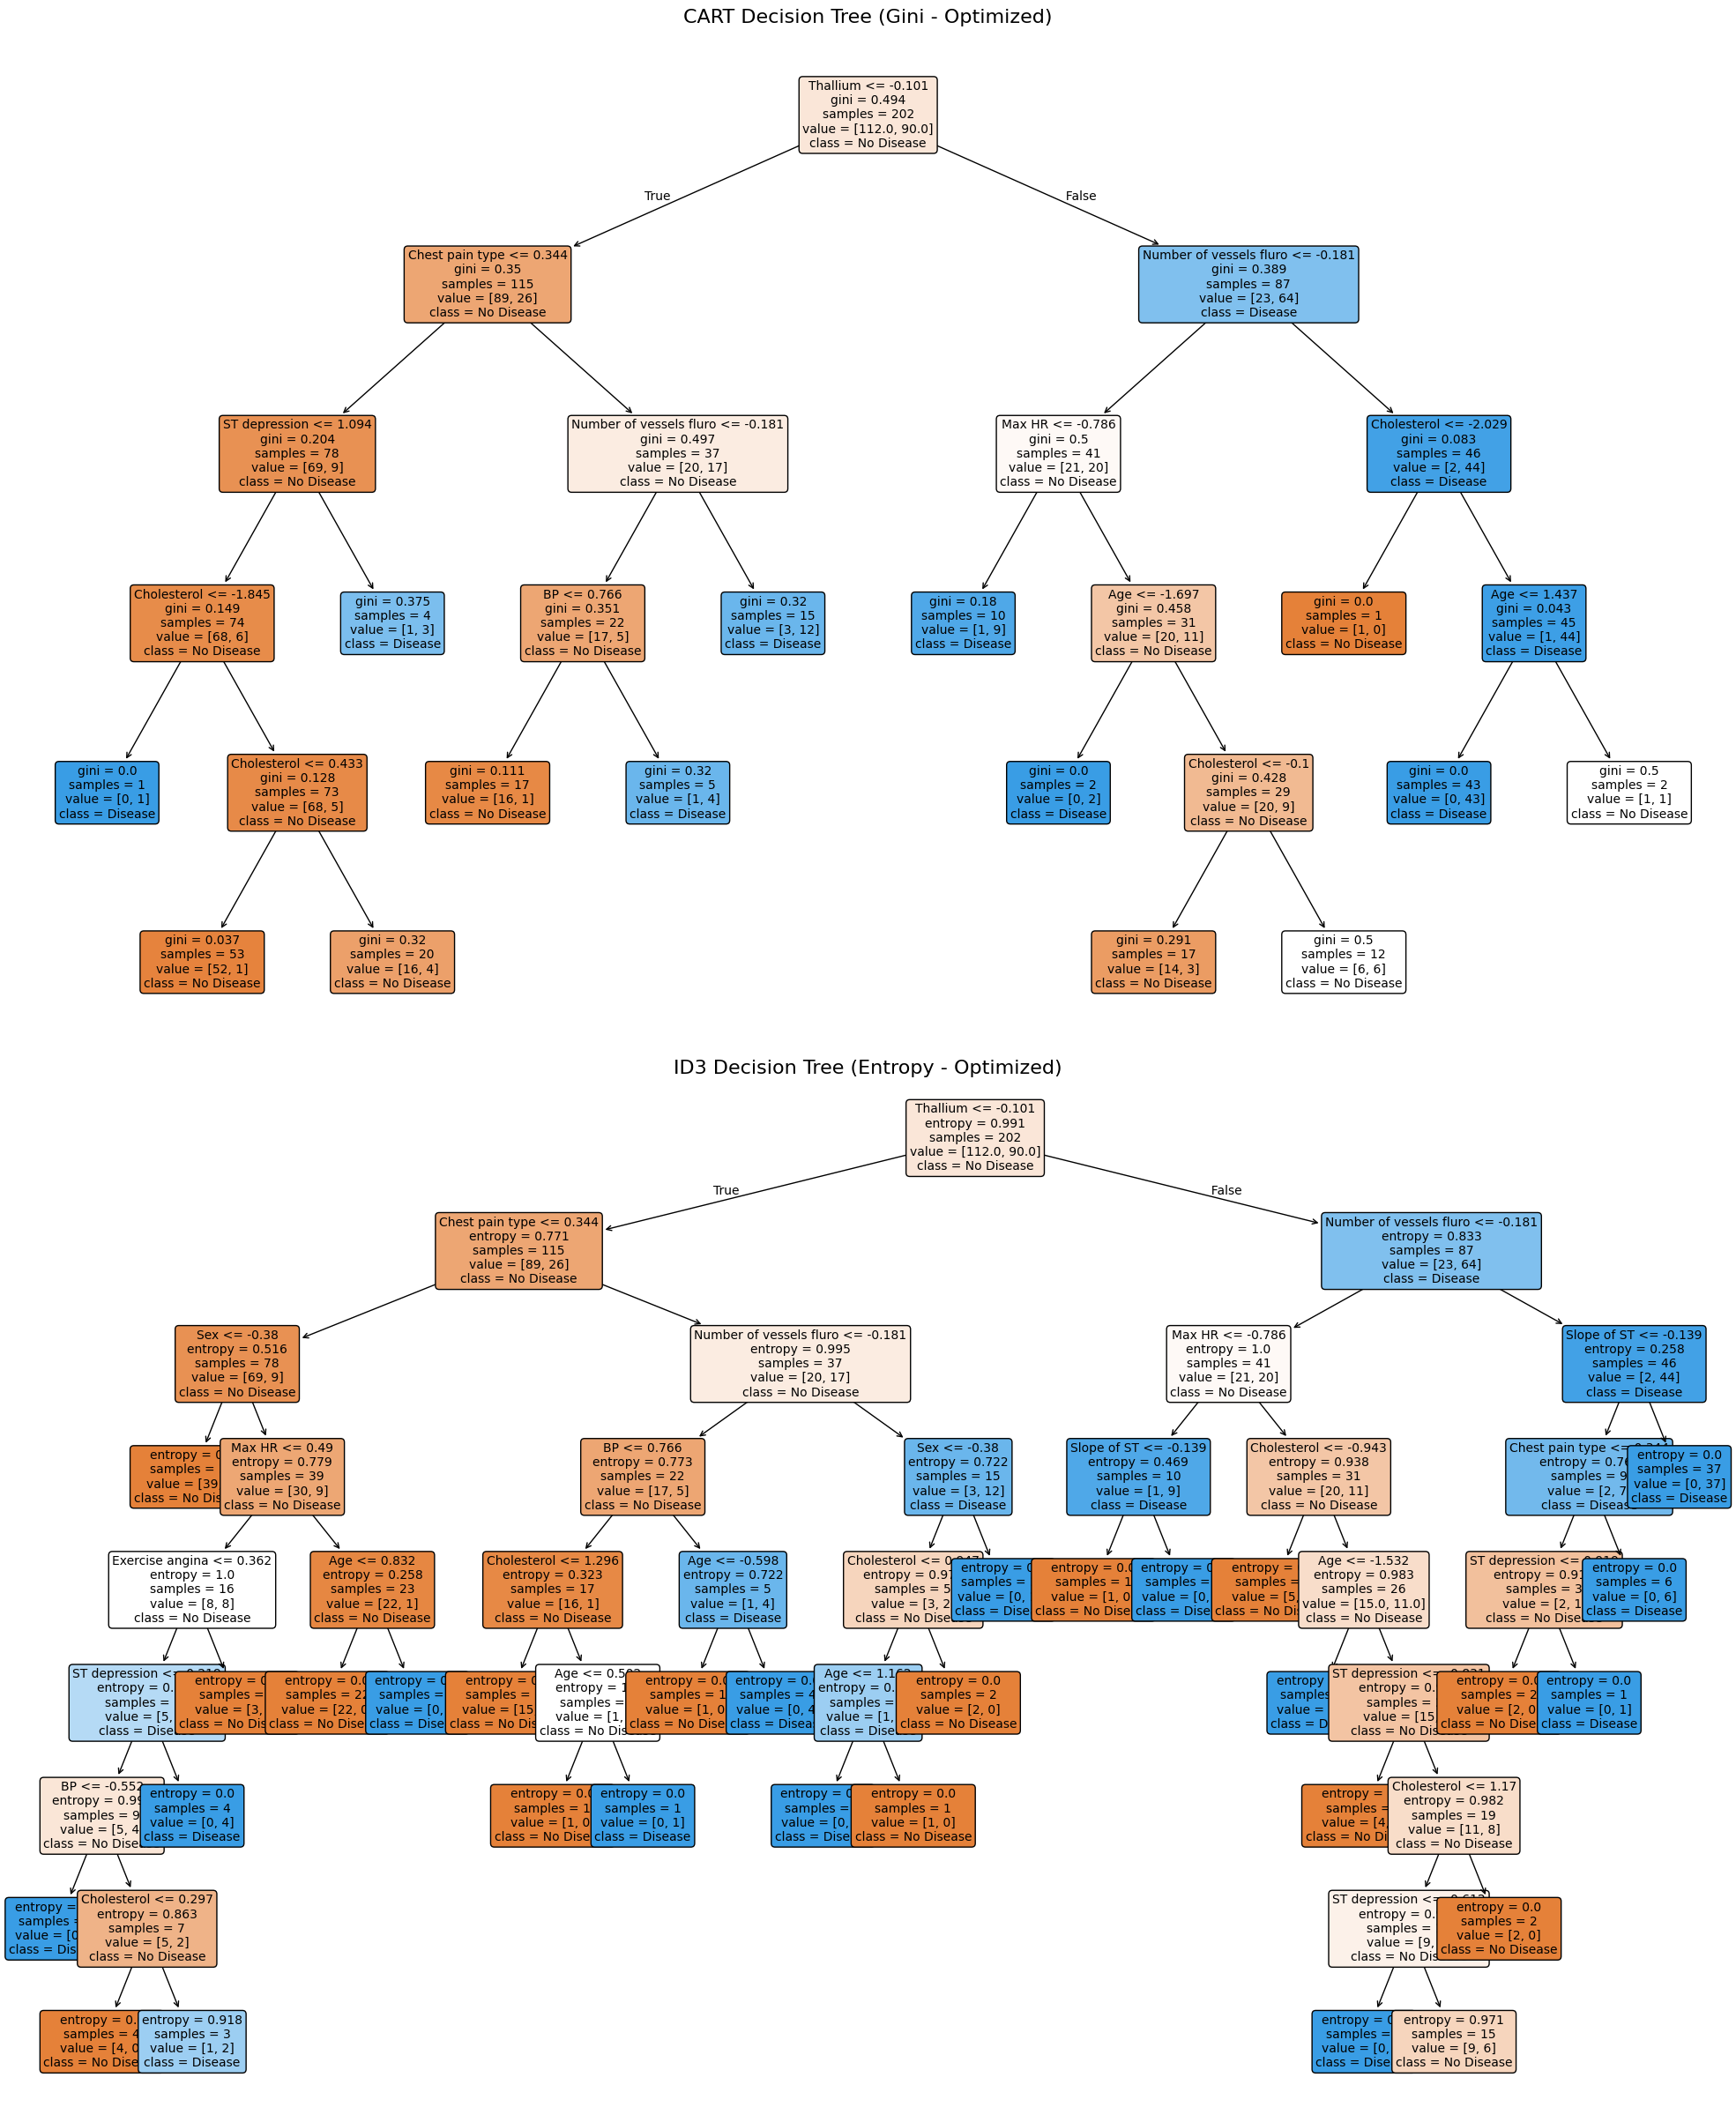

In [26]:
plt.figure(figsize=(20, 24))

plt.subplot(2, 1, 1)
plot_tree(
    best_cart,
    feature_names=X.columns,
    class_names=["No Disease", "Disease"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("CART Decision Tree (Gini - Optimized)", fontsize=16)

plt.subplot(2, 1, 2)
plot_tree(
    best_id3,
    feature_names=X.columns,
    class_names=["No Disease", "Disease"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("ID3 Decision Tree (Entropy - Optimized)", fontsize=16)

plt.tight_layout()
plt.show()
